In [1]:
import pandas as pd

In [2]:
year = 2017

In [3]:
clustered = pd.read_csv("clustered_data.csv")
clustered

,traj,obs,old_traj,longitude,latitude,cluster_id
0,0,0,8,-22.691607,16.029816,-1
1,0,1,8,-22.685192,15.991036,-1
2,0,2,8,-22.683147,15.967465,-1
3,0,3,8,-22.692963,15.966416,-1
4,0,4,8,-22.705220,15.973639,-1
...,...,...,...,...,...,...
292056,999,253,9964,-49.320366,10.847726,0
292057,999,254,9964,-49.505756,10.759947,0
292058,999,255,9964,-49.673706,10.700109,0
292059,999,256,9964,-49.828434,10.668164,0


In [4]:
from lagrangian_trajectory_clustering.trafo.sequence import (
    fill_in_segments,
    multi_index_series_to_series_sequences,
    remove_subsequent_identical_elements,
)
from lagrangian_trajectory_clustering.trafo.grid import (
    geo_df_to_grid_series, 
    grid_series_to_geo_df,
)

In [5]:
lat_lon_res = 7

In [6]:
lat_num = int(180 // (abs(clustered.latitude.max() - clustered.latitude.min()) / lat_lon_res) + 1)
lon_num = int(360 // (abs(clustered.longitude.max() - clustered.longitude.min()) / lat_lon_res) + 1)
print(lon_num, lat_num)

58 93


In [7]:
clustered.set_index(clustered.traj).cluster_id

traj
0     -1
0     -1
0     -1
0     -1
0     -1
      ..
999    0
999    0
999    0
999    0
999    0
Name: cluster_id, Length: 292061, dtype: int64

In [8]:
clustered_sequential_data = fill_in_segments(
    remove_subsequent_identical_elements(
        multi_index_series_to_series_sequences(
            geo_df_to_grid_series(
                clustered.reset_index().set_index(["traj", "obs"])[["latitude", "longitude"]],
                lon_num=lon_num,
                lat_num=lat_num,
            )
        )
    )
)

clustered_sequential_data = (
    clustered_sequential_data.to_frame()
    .join(clustered["cluster_id"].groupby(clustered.traj).first())
)

display(clustered_sequential_data)

,grid_index_lon_lat,cluster_id
traj,,
0,"[(53, 54), (53, 53), (52, 53), (51, 53), (51, ...",-1
1,"[(53, 54), (53, 53), (52, 53), (52, 54), (51, ...",-1
2,"[(53, 54), (53, 53), (52, 53), (51, 53), (51, ...",-1
3,"[(53, 54), (53, 53), (52, 53), (51, 53), (51, ...",-1
4,"[(53, 54), (53, 53), (52, 53), (52, 52), (52, ...",0
...,...,...
995,"[(53, 54), (53, 53), (52, 53), (51, 53), (51, ...",0
996,"[(53, 54), (53, 53), (52, 53), (51, 53), (51, ...",0
997,"[(53, 54), (53, 53), (52, 53), (51, 53), (51, ...",0


In [9]:
cluster_groups = [x for _, x in clustered_sequential_data["grid_index_lon_lat"].groupby(clustered_sequential_data.cluster_id)]
cluster_groups[0]

traj
0      [(53, 54), (53, 53), (52, 53), (51, 53), (51, ...
1      [(53, 54), (53, 53), (52, 53), (52, 54), (51, ...
2      [(53, 54), (53, 53), (52, 53), (51, 53), (51, ...
3      [(53, 54), (53, 53), (52, 53), (51, 53), (51, ...
16     [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
199    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
201    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
202    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
203    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
204    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
205    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
207    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
209    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
211    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
213    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
216    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
614    [(53, 54), (53, 53), (52, 53), (52, 52), (52, ...
637    [(53, 54), (53, 53)

In [10]:
from lagrangian_trajectory_clustering.metrics import levenshtein_numpy_numba, lcs_numpy_numba

In [11]:
import numpy as np

In [12]:
# lcs_dist = lambda s0, s1: max(len(s0), len(s1)) / lcs_numpy_numba(s0, s1) - 1
lcs_dist = lambda s0, s1: 1 - lcs_numpy_numba(s0, s1) / max(len(s0), len(s1))

In [13]:
dist_mat_list = [
    np.array(
        [
            cluster_groups[ngroup].apply(lambda s: lcs_dist(s, cluster_groups[ngroup].iloc[n]))
            for n in range(len(cluster_groups[ngroup]))
        ]
    ) for ngroup in range(len(cluster_groups))
]

/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'x' of function 'lcs_numpy'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../lagrangian_trajectory_clustering/metrics.py", line 6:

def lcs_numpy(x, y):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'y' of function 'lcs_numpy'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../lagrangian_trajectory_clustering/metrics.py", line 6:

def lcs_numpy(x, y):
^



In [14]:
list(map(np.shape, dist_mat_list))

[(25, 25), (684, 684), (238, 238), (27, 27), (7, 7), (11, 11), (8, 8)]

In [15]:
lcs_numpy_numba(cluster_groups[4].apply(tuple).unique()[0], cluster_groups[4].apply(tuple).unique()[1])

23

In [16]:
lcs_dist(cluster_groups[4].apply(tuple).unique()[0], cluster_groups[4].apply(tuple).unique()[1])

0.0

In [17]:
ref_traj_num = pd.Series(
    [np.argmin(np.sum(dm, axis=-1)) for dm in dist_mat_list],
)
ref_traj_num

0    19
1    18
2     4
3     7
4     0
5     0
6     1
dtype: int64

In [28]:
cluster_widths = pd.Series(
    [np.max(dm[rt, :]) for dm, rt in zip(dist_mat_list, ref_traj_num)],
)
cluster_widths += 1e-7  # ensure nonzero width to catch roundoff
cluster_widths

0    6.666668e-01
1    4.000001e-01
2    1.428572e-01
3    8.695662e-02
4    1.000000e-07
5    1.000000e-07
6    4.347836e-02
dtype: float64

In [29]:
from matplotlib import pyplot as plt

In [39]:
ref_traj_ind = pd.Series(
    [cg.index[rtn] for cg, rtn in zip(cluster_groups, ref_traj_num)],
    index=ref_traj_num.index,
)
ref_traj_ind

0    653
1     26
2     49
3    623
4    616
5    613
6    611
dtype: int64

In [43]:
ref_traj_seq = clustered_sequential_data.loc[ref_traj_ind]
ref_traj_seq

,grid_index_lon_lat,cluster_id
traj,,
653,"[(53, 54), (53, 53), (52, 53), (52, 52), (52, ...",-1
26,"[(53, 54), (53, 53), (52, 53), (51, 53), (51, ...",0
49,"[(53, 54), (53, 53), (52, 53), (52, 52), (51, ...",1
623,"[(53, 54), (53, 53), (52, 53), (52, 52), (52, ...",2
616,"[(53, 54), (53, 53), (52, 53), (52, 52), (52, ...",3
613,"[(53, 54), (53, 53), (52, 53), (52, 52), (52, ...",4
611,"[(53, 54), (53, 53), (52, 53), (52, 52), (52, ...",5


In [44]:
ref_traj_full = clustered.set_index(["traj", "obs"]).loc[ref_traj_ind]
ref_traj_full

old_traj  longitude   latitude  cluster_id
traj obs                                            
653  0        6692 -22.691143  16.029333          -1
     1        6692 -22.735670  15.995206          -1
     2        6692 -22.814993  15.954249          -1
     3        6692 -22.923914  15.915742          -1
     4        6692 -23.026970  15.858001          -1
...            ...        ...        ...         ...
611  730      6174  -7.983675   4.192977           5
     731      6174  -7.518194   4.120894           5
     732      6174  -6.990498   4.173807           5
     733      6174  -6.498611   4.297916           5
     734      6174  -6.498611   4.297916           5

[3253 rows x 4 columns]

In [49]:
from lagrangian_trajectory_clustering.data_loading import (
    load_cape_verde_trajectories,
    reindex_trajectories,
)

In [50]:
raw_data = load_cape_verde_trajectories(year=year)

display(raw_data)

time   latitude  longitude
traj obs                                 
0    0   1997-08-14  16.030224 -22.692162
     1   1997-08-15  16.017056 -22.714727
     2   1997-08-16  15.994600 -22.739052
     3   1997-08-17  15.954251 -22.766460
     4   1997-08-18  15.938750 -22.811235
...             ...        ...        ...
9999 248 1998-06-07   9.679025 -49.273670
     249 1998-06-08   9.653998 -49.456814
     250 1998-06-09   9.652131 -49.642100
     251 1998-06-10   9.651998 -49.820766
     252 1998-06-10   9.651998 -49.820766

[2967450 rows x 3 columns]

In [52]:
from matplotlib import pyplot as plt

CPU times: user 166 ms, sys: 95.3 ms, total: 262 ms
Wall time: 188 ms


cluster_id
-1    AxesSubplot(0.125,0.125;0.775x0.755)
 0    AxesSubplot(0.125,0.125;0.775x0.755)
 1    AxesSubplot(0.125,0.125;0.775x0.755)
 2    AxesSubplot(0.125,0.125;0.775x0.755)
 3    AxesSubplot(0.125,0.125;0.775x0.755)
 4    AxesSubplot(0.125,0.125;0.775x0.755)
 5    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

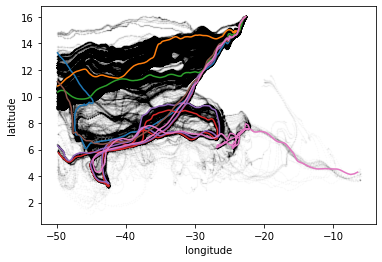

In [53]:
%%time

fig, ax = plt.subplots(1, 1)

raw_data.plot.scatter(x="longitude", y="latitude", s=1, alpha=0.01, color="black", ax=ax)
ref_traj_full.groupby("cluster_id").plot.line(x="longitude", y="latitude", ax=ax, legend=False);

In [54]:
from lagrangian_trajectory_clustering.trafo.grid import (
    geo_df_to_grid_series,  # lat lon coords to grid index
    grid_series_to_geo_df,  # grid index to lat lon coords
)

from lagrangian_trajectory_clustering.trafo.sequence import (
    remove_subsequent_identical_elements,  # transorm to sequence of unique subsequent elemets
    multi_index_series_to_series_sequences,  # transform to series of sequences
    series_sequences_to_multi_index_series,  # transform back from series of sequences
    fill_in_segments,  # fill in jumps leaping over grid boxes
)

In [55]:
lat_lon_res = 7

In [56]:
lat_num = int(180 // (abs(raw_data.latitude.max() - raw_data.latitude.min()) / lat_lon_res) + 1)
lon_num = int(360 // (abs(raw_data.longitude.max() - raw_data.longitude.min()) / lat_lon_res) + 1)
print(lon_num, lat_num)

58 85


In [57]:
%%time

raw_data_roundtrip = grid_series_to_geo_df(
    series_sequences_to_multi_index_series(
        fill_in_segments(
            remove_subsequent_identical_elements(
                multi_index_series_to_series_sequences(
                    geo_df_to_grid_series(
                        raw_data,
                        lon_num=lon_num,
                        lat_num=lat_num,
                    )
                )
            )
        )
    ),
    lon_num=lon_num,
    lat_num=lat_num,
)

display(raw_data_roundtrip)

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


longitude   latitude
traj obs                       
0    0    337.894737  16.071429
     1    337.894737  13.928571
     2    337.894737  16.071429
     3    337.894737  13.928571
     4    331.578947  13.928571
...              ...        ...
9999 3    325.263158  13.928571
     4    325.263158  11.785714
     5    318.947368  11.785714
     6    312.631579  11.785714
     7    312.631579   9.642857

[94388 rows x 2 columns]

CPU times: user 5.06 s, sys: 174 ms, total: 5.23 s
Wall time: 5.24 s


In [58]:
sequential_data = fill_in_segments(
    remove_subsequent_identical_elements(
        multi_index_series_to_series_sequences(
            geo_df_to_grid_series(
                raw_data,
                lon_num=lon_num,
                lat_num=lat_num,
            )
        )
    )
)

display(sequential_data)

traj
0       [(53, 49), (53, 48), (53, 49), (53, 48), (52, ...
1       [(53, 49), (53, 48), (53, 49), (53, 48), (52, ...
2       [(53, 49), (53, 48), (52, 48), (52, 49), (52, ...
3       [(53, 49), (52, 49), (52, 48), (51, 48), (50, ...
4       [(53, 49), (52, 49), (52, 48), (52, 49), (51, ...
                              ...                        
9995    [(53, 49), (53, 48), (52, 48), (51, 48), (51, ...
9996    [(53, 49), (53, 48), (52, 48), (51, 48), (51, ...
9997    [(53, 49), (53, 48), (52, 48), (51, 48), (51, ...
9998    [(53, 49), (53, 48), (52, 48), (51, 48), (51, ...
9999    [(53, 49), (53, 48), (52, 48), (51, 48), (51, ...
Name: grid_index_lon_lat, Length: 10000, dtype: object

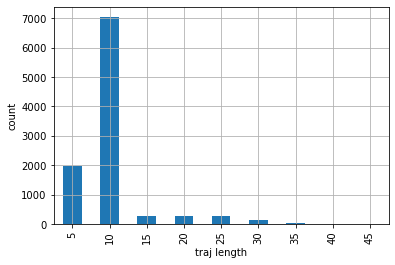

In [59]:
ax = sequential_data.apply(len).apply(lambda l: int(round(2 * l, -1) / 2)).value_counts().sort_index().plot.bar();
ax.grid()
ax.set_xlabel("traj length")
ax.set_ylabel("count");

In [60]:
sequential_data.apply(len).describe()

count    10000.000000
mean         9.438800
std          4.481926
min          6.000000
25%          8.000000
50%          8.000000
75%          9.000000
max         46.000000
Name: grid_index_lon_lat, dtype: float64

In [80]:
%%time

dist_matrix = np.array(
    [
        sequential_data.apply(lambda s: lcs_dist(s, ref_traj_seq.iloc[n, 0]))
        for n in range(len(ref_traj_seq))
    ]
)

CPU times: user 31 s, sys: 19.3 ms, total: 31 s
Wall time: 31.2 s


In [82]:
np.argmin(dist_matrix, axis=-1)

array([ 9,  0,  0, 21, 21,  9, 21])

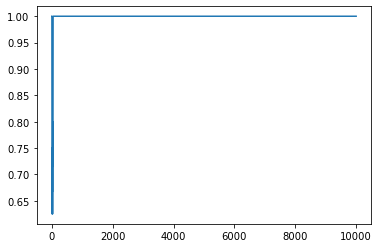

In [81]:
plt.plot(dist_matrix[0, :])

In [77]:
sequential_data.loc[clustered.set_index("traj").old_traj.loc[ref_traj_seq.index]].iloc[0]

[(53, 49),
 (53, 48),
 (52, 48),
 (52, 47),
 (52, 46),
 (51, 46),
 (51, 45),
 (50, 45),
 (49, 45),
 (49, 44),
 (49, 45),
 (49, 46),
 (49, 47),
 (49, 48)]

In [79]:
ref_traj_seq.iloc[0, 0]

[(53, 54),
 (53, 53),
 (52, 53),
 (52, 52),
 (52, 51),
 (52, 50),
 (51, 50),
 (51, 49),
 (50, 49),
 (49, 49),
 (49, 50),
 (49, 51),
 (49, 52)]

In [74]:
dist_matrix.min(axis=-1)

array([0.625, 1.   , 1.   , 0.375, 0.5  , 0.625, 0.5  ])

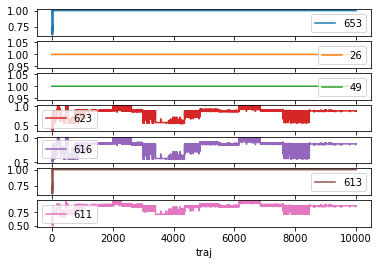

In [73]:
pd.DataFrame(dist_matrix.T, columns=ref_traj_seq.index, index=sequential_data.index).plot(subplots=True);

In [ ]:
label = pd.Series(cluster_ref_traj.index[dist_matrix.argmin(axis=0)], index=sequential_data.index, name="label")
display(label)
label.plot.hist()

In [ ]:
labeled_data = raw_data.join(label).reset_index().set_index(["label", "traj", "obs"])
labeled_data

In [ ]:
%%time

fig, ax = plt.subplots(
    len(sequential_data_refs), 1,
    figsize=(7, len(sequential_data_refs) * 2),
    sharex=True, sharey=True,
)
ax = ax.flatten()

for lab, _ax, rt in zip(label.unique(), ax, [x for _, x in ref_trajs.groupby("traj")]):

    raw_data.plot.scatter(x="longitude", y="latitude", s=1, alpha=0.01, color="black", ax=_ax)
    labeled_data.loc[lab].plot.scatter(x="longitude", y="latitude", s=2, alpha=0.1, color="orange", ax=_ax);
    rt.plot.line(x="longitude", y="latitude", ax=_ax, linewidth=3, color="blue", legend=False);